| <font size=6,font color='red'>Monôme / binôme</font> | <font size=6,font color='red'>Nom</font> | <font size=6,font color='red'>Prénom</font>   |
|:-------------:     |:-----------   |:------  |
| binôme 1  | <span style="color:red">ROUDAUT</span> | <span style="color:red">Tanguy</span>     |
| binôme 2         | <span style="color:red">DUBEE</span> | <span style="color:red">Melvin</span>     |








# <center> **Reinforcement Learning with a policy gradient algorithm** </center>
## <center> Machine Learning Programming Exercise 12</center>


Ce TP concerne la découverte de l'apprentissage par renforcement appliqué au domaine du gaming. Les observations seront données par un émulateur de jeux atari. L'objectif de ce tp est la mise en oeuvre de différents algorithmes de type **policy gradient**.




# 1. Import useful packages

## 1.1 Colab or not colab

In [5]:
# common imports
import sys,os,glob

# Colab preamble
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:

  # mount google drive directories
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)

  # replace the ipynb_name (below) with the name of your jupyter notebook file

  # ----------- Your code here --------------------->

  # ipynb_name = 'tp_rl_pg_solution.ipynb'
  ipynb_name = 'tp_rl_pg_startercode_MelvinDUBEE_TanguyROUDAUT.ipynb'

  # ------------------------------------------------>

  ipynb_name = glob.glob(os.getcwd() + '/gdrive/MyDrive/machine_learning/tp12/' + ipynb_name, recursive = True)
  code_folder = os.path.dirname(ipynb_name[0])

  # change to the right folder
  %cd "$code_folder"
  !ls

## 1.2 Import packages

In [6]:
# common imports
import numpy as np

# display imports
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
matplotlib.rc('animation', html='jshtml') # To get smooth animations




# ML imports
import tensorflow as tf

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IN_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

elif len(tf.config.list_physical_devices('GPU')) > 1:
  # a décommenter si problème avec le GPU de votre machine
  physical_devices = tf.config.experimental.list_physical_devices('GPU')

  for gpu in physical_devices:
      tf.config.experimental.set_memory_growth(gpu, True)


# RL imports:  install specific packages for openai/gym envs

# install gym
%pip install -q -U gymnasium
%pip install -q -U gymnasium[classic_control]
%pip install -q -U gymnasium[atari]
%pip install -q -U gymnasium[accept-rom-license]
%pip install pyvirtualdisplay


No GPU was detected. CNNs can be very slow without a GPU.


Note: you may need to restart the kernel to use updated packages.
zsh:1: no matches found: gymnasium[classic_control]
Note: you may need to restart the kernel to use updated packages.
zsh:1: no matches found: gymnasium[atari]
Note: you may need to restart the kernel to use updated packages.
zsh:1: no matches found: gymnasium[accept-rom-license]
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## 1.3 Setup

In [7]:
# initialisation des graines aléatoires
SEED = 333
np.random.seed(SEED)
tf.random.set_seed(SEED)


## 1.4 some useful functions

In [ ]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

# 2. Introduction to OpenAI gym (facultatif si vous l'avez déjà fait)

C'est le même que dans le tp sur les algorithmes `Q_learning`. Si vous l'avez déjà fait, passez directement à la section suivante.


Dans ce notebook, l'environnement et les observations/données seront fournis par le framework [OpenAI gym](https://gym.openai.com/). Il fournit de nombreux environnements avec lesquels votre *agent* peut interagir et apprendre une policy.
L'import se fait classiquement par:

In [ ]:
#import gym
import gymnasium as gym

gym.__version__

'0.29.1'

La liste des environnements disponibles est donnée par:

In [ ]:
g = gym.envs.registry
for l in list(g):
  print(l)



CartPole-v0
CartPole-v1
MountainCar-v0
MountainCarContinuous-v0
Pendulum-v1
Acrobot-v1
phys2d/CartPole-v0
phys2d/CartPole-v1
phys2d/Pendulum-v0
LunarLander-v2
LunarLanderContinuous-v2
BipedalWalker-v3
BipedalWalkerHardcore-v3
CarRacing-v2
Blackjack-v1
FrozenLake-v1
FrozenLake8x8-v1
CliffWalking-v0
Taxi-v3
tabular/Blackjack-v0
tabular/CliffWalking-v0
Reacher-v2
Reacher-v4
Pusher-v2
Pusher-v4
InvertedPendulum-v2
InvertedPendulum-v4
InvertedDoublePendulum-v2
InvertedDoublePendulum-v4
HalfCheetah-v2
HalfCheetah-v3
HalfCheetah-v4
Hopper-v2
Hopper-v3
Hopper-v4
Swimmer-v2
Swimmer-v3
Swimmer-v4
Walker2d-v2
Walker2d-v3
Walker2d-v4
Ant-v2
Ant-v3
Ant-v4
Humanoid-v2
Humanoid-v3
Humanoid-v4
HumanoidStandup-v2
HumanoidStandup-v4
GymV26Environment-v0
GymV21Environment-v0
Adventure-v0
AdventureDeterministic-v0
AdventureNoFrameskip-v0
Adventure-v4
AdventureDeterministic-v4
AdventureNoFrameskip-v4
Adventure-ram-v0
Adventure-ramDeterministic-v0
Adventure-ramNoFrameskip-v0
Adventure-ram-v4
Adventure-ramDe

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 2.1 Le Cart-Pole

Le [Cart-Pole](https://gym.openai.com/envs/CartPole-v1/) est un environnement très simple dans lequel un chariot peut bouger soit vers la gauche, soit vers la droite. Un bâton/piquet est placé sur ce dernier. L'agent doit alors bouger le chariot à gauche ou à droite pour que le bâton reste droit.
<table align="center">
<td align="center">
<img src="https://drive.google.com/uc?id=1RNWq3McGaTydH2PrNQWFcXLxV7Lg2mC8" height="300px" />
<td/>
</table>

L'environnement est défini par la commande `make()`:

In [ ]:
env = gym.make('CartPole-v1', render_mode="rgb_array")

Il faut ensuite initialiser l'environnement en appelant la méthode `reset()` qui retourne la première observation.

In [ ]:
SEED = 333
obs = env.reset(seed=SEED)
obs

(array([0.04190018, 0.03315072, 0.00547609, 0.03063206], dtype=float32), {})

Les observations dépendent de l'environnement considéré. Dans ce cas, les observations sont regroupées dans un array Numpy 1D soit 1 vecteur composé de 4 floats. Ce vecteur regroupe:
- la position horizontale du chariot (<0 gauche; 0 = verticale; >0 droite)
- la vitesse du chariot  
- l'angle du bâton (<0 gauche; 0 = verticale; >0 droite)
- la vitesse angulaire


Un environnement peut-être visualisé par appel à la méthode `render()`. Pour récupérer une observation (une image) de l'environnement sous la forme d'un array NumPy:

In [ ]:
img = env.render()
img.shape

(400, 600, 3)

La fonction `plot_environment()` permet de récupérer et d'afficher l'observation courante de l'environnement.

In [ ]:
def plot_environment(env, figsize=(5,4)):
    # get an observation
    img = env.render()

    # display an observation
    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.axis("off")
    return img

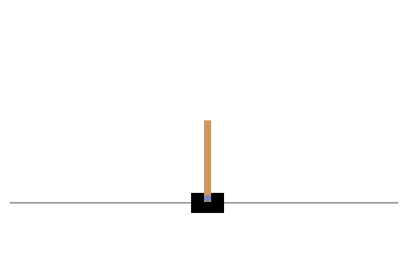

In [ ]:
plot_environment(env)
plt.show()

Pour interagir avec l'environnement, l'agent doit sélectionner une action à partir de l'espace des actions possibles. Pour chaque environnement, la commande `action_space` permet de connaitre cet espace.

In [ ]:
env.action_space

Discrete(2)

Pour le cartpole,deux actions sont possible: gauche ou droite.

Dans l'état actuel, le bâton est penché vers la droite (`obs[2] > 0`); passons l'action de déplacer le chariot vers la droite.

In [ ]:
# action
go_right = True  # or 1, go right
# go_right = False # or 0, go left

# interaction with the environment
obs, reward, done, truncated, info = env.step(go_right)

# observation
obs

array([ 0.0425632 ,  0.22819372,  0.00608873, -0.2603181 ], dtype=float32)

Remarquez que:
- le chariot se déplace maintenant vers la droite (`obs[1] > 0`);
- le bâton est toujours incliné vers la droite (`obs[2] > 0`) ;
- mais sa vitesse angulaire est maintenant négative (`obs[3] < 0`), il est ainsi vraissemblable qu'il soit incliné vers la gauche après la prochaine action.

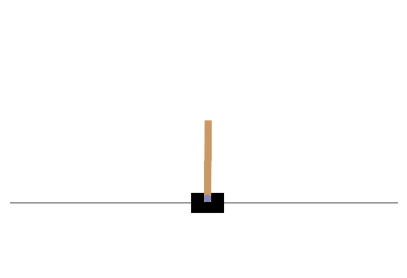

In [ ]:
plot_environment(env);


L'interaction avec l'environnement:
- génère l'observation suivante `obs`
- renseigne l'agent sur la récompense générée par l'action prise: `reward`
- retourne `done=True` si le jeu est fini (pour cet environnement, le jeu est fini si l'angle du baton est de plus de 12° ou si le chariot s'est déplacé de plus 2.4 unités par rapport au centre.)
- `truncated`: cette valeur sera `True` lorsqu'un épisode est interrompu prématurément, par exemple par un wrapper d'environnement qui impose un nombre maximum d'étapes par épisode (voir la documentation de Gym pour plus de détails sur les wrappers d'environnement).
- info est un dictionnaire spécifique à chaque environnement qui peut contenir des informations supplémentaires pour le debugging ou l'apprentissage.

In [ ]:
print(reward, done, truncated)

1.0 False False


Comme nous l'avons vu en cours, un **épisode** correspond à la séquence d'interactions entre le moment où l'environnement est lancé `reset()` et le moment ou `done=True`. Pour relancer un épisode, il faut refaire appel à la méthode `reset()`.

In [ ]:
if done or truncated:
  obs = env.reset(seed=SEED)


## 2.2 Autres environnement (facultatif)

**Question:**
- **Charger l'environnement SpaceInvaders-v0**
- **Déterminer :**
  - **l'espace d'actions**
  - **l'espace d'observation**

- **et créer une image/copie de chaque environnement**

In [ ]:
# ----------- Your code here --------------------->

space_invaders = gym.make('SpaceInvaders-v0')
action_space = space_invaders.action_space
observation_space = space_invaders.observation_space

print("Espace d'actions:", action_space)
print("Espace d'observation:", observation_space)

# ------------------------------------------------>


/usr/local/lib/python3.10/dist-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment SpaceInvaders-v0 is out of date. You should consider upgrading to version `v4`.
  logger.deprecation(


Espace d'actions: Discrete(6)
Espace d'observation: Box(0, 255, (210, 160, 3), uint8)


# 3. Définition d'une politique simple (policy)

Revenons au **CartPole** et essayons de maintenir le bâton droit. Nous avons besoin d'une policy (politique/stratégie) pour cela. Il s'agit d'une stratégie que l'agent utilisera pour sélectionner une action à chaque étape. Cette stratégie pourra potentiellement utiliser toutes les actions et observations passées pour faire cela.

Pour le moment, nous allons définir une politique très simple consistant à déplacer le chariot vers la gauche (resp. la droite) quand il penche vers la gauche (resp. la droite). Ici, la policy $\pi_{\theta}(\mathbf{a}_t|\mathbf{o}_t)$ est déterministe pourra donc s'écrire $\mathbf{a}_t = \pi(\mathbf{o}_t)$.

**Question 3.1: Pour l'implémentation vous créerez:**
- **une fonction `select_action_simple_policy(obs)` retournant l'action à prendre en fonction de l'observation**
- **un script qui permet de**
 - **générer `N_EPISODES` (500) **épisodes** (ou **trajectoires**, **roll_out**)**
 - **chacun de ces épisodes comprend un nombre max d'interactions (de pas temporels) avec l'environnement fixé à `N_STEPS_MAX_PER_EPISODE = 200`**
 - **pour chaque interaction (pas temporel), décider de l'action à prendre (appel à `select_action_simple_policy()`), jouer cette action en interagissant avec l'environnement et récupérer la récompense et calculer la récompense totale**
 - **calculer les performances de l'algorithme (les statistiques: moyenne, std, min, max)**


**Notes**: deux boucles imbriquées sont à coder, vous pouvez suivre le squellette suivant


In [ ]:
import gymnasium as gym
env = gym.make('CartPole-v1', render_mode="rgb_array")

In [ ]:

# policy definition
def select_action_simple_policy(obs):

# ----------- Your code here --------------------->

    if obs[2] > 0:
        go_right = True
    else:
        go_right = False


# ------------------------------------------------>
    return go_right


In [ ]:

# parameters
N_EPISODES = 500
N_STEPS_MAX_PER_EPISODE = 200


In [ ]:
# boucle sur les épisodes/loop over the episodes
episode_cumrewards_history=[]
for episode in range(N_EPISODES):

    # starting a new episode
    episode_cumrewards = 0
    obs, info = env.reset(seed=episode)

    # ...with N_STEPS_MAX_PER_EPISODE interactions (temps)
    for step in range(N_STEPS_MAX_PER_EPISODE):

# ----------- Your code here --------------------->

      ## starting a new interaction ##

      # select an action
      go_right = select_action_simple_policy(obs)

      # interaction with the environment
      obs, reward, done, truncated, info = env.step(go_right)

      # compute cumulative reward
      episode_cumrewards += reward

# ------------------------------------------------>

      # continue or not
      if done or truncated:
        print('break at {}: done={},  truncated={}'.format(step, done, truncated))
        break

    # performance statistics
    episode_cumrewards_history.append(episode_cumrewards)

break at 40: done=True,  truncated=False
break at 50: done=True,  truncated=False
break at 34: done=True,  truncated=False
break at 35: done=True,  truncated=False
break at 24: done=True,  truncated=False
break at 38: done=True,  truncated=False
break at 31: done=True,  truncated=False
break at 33: done=True,  truncated=False
break at 44: done=True,  truncated=False
break at 47: done=True,  truncated=False
break at 50: done=True,  truncated=False
break at 42: done=True,  truncated=False
break at 48: done=True,  truncated=False
break at 51: done=True,  truncated=False
break at 34: done=True,  truncated=False
break at 50: done=True,  truncated=False
break at 38: done=True,  truncated=False
break at 38: done=True,  truncated=False
break at 35: done=True,  truncated=False
break at 36: done=True,  truncated=False
break at 24: done=True,  truncated=False
break at 35: done=True,  truncated=False
break at 24: done=True,  truncated=False
break at 39: done=True,  truncated=False
break at 44: don

**Question 3.2: Affichez:**
- **la récompense cumulée moyenne +/- écart type calculée sur les épisodes**
- **l'évolution de la récompense cumulée au cours des épisodes**


**_`Your commented code below`_**

Récompense cumulée moyenne: 41.698 +/- 8.389445512070509


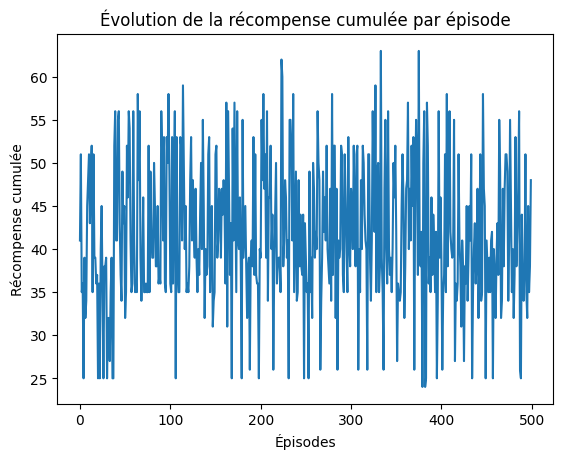

In [ ]:
# ----------- Your code here --------------------->

mean_reward = np.mean(episode_cumrewards_history)
std_reward = np.std(episode_cumrewards_history)

print(f"Récompense cumulée moyenne: {mean_reward} +/- {std_reward}")

plt.plot(episode_cumrewards_history)
plt.title("Évolution de la récompense cumulée par épisode")
plt.xlabel("Épisodes")
plt.ylabel("Récompense cumulée")
plt.show()
# ------------------------------------------------>

# expected value 41.698 +/- 8.389445512070509


**Question 3.3**: Quelles sont vos conclusions sur les performances obtenues?


**_`Double cliquez ici pour écrire votre réponse ici!`_**




Vous pouvez visualiser l'évolution du cartpole au cours d'un episode avec la boucle suivante.

**Question 3.4: Complétez les lignes demandées.**

In [ ]:

# initialisation
frames = []
obs, info = env.reset(seed=SEED)

# boucle temporelle d'interactions, un step = un pas temporel = une interaction
for step in range(N_STEPS_MAX_PER_EPISODE):

    # recuperation de l'environnement courant
    img = env.render()
    frames.append(img)

# ----------- Your code here --------------------->

    # selectionner une action
    go_right = select_action_simple_policy(obs)

# ------------------------------------------------>

# ----------- Your code here --------------------->

    # interaction avec l'environnement
    obs, reward, done, truncated, info = env.step(go_right)

# ------------------------------------------------>

    # continue or not
    if done or truncated:
        print('break at {}: done={},  truncated={}'.format(step, done, truncated))
        break


break at 62: done=True,  truncated=False


Vous pouvez définir un lecteur d'animation.

In [ ]:
plot_animation(frames)

# 4. Politiques par réseau de neurones (Neural Network Policies)

Nous allons la remplacer la policy avec une stratégie trop simple par un réseau de neurones permettant plus de complexité.



## 4.1 Création d'un réseau de neurones pour la policy

**Question 4.1: Commencer par créer un model séquentiel de réseau de neurones à deux couches dense :**
- **Ce réseau prendra une observation en entrée. Quelle est la taille des entrées?**
- **La couche cachée sera de 5 neurones et l'activation de type `relu`.**
- **Ce réseau prédira l'action à prendre pour chaque observation. Pour choisir l'action, le réseau estimera la probabilité d'aller à gauche pour chaque action.**
- **Quel est le nombre de neurones de la couche de sortie? Quelle sera la fonction d'activation de la dernière couche? Pourquoi?**
- **Comment prendre la décision d'aller à gauche ou à droite lors de la prochaine interaction?**

**Notes sur observations et états**:
Dans cet environnement particulier, les actions passées et les observations peuvent être ignorées car chaque observation contient l'état complet de l'environnement. Si par exemple, l'observation ne contenait pas la vitesse du chariot, on aurait besoin de quelques observations successives de la position du chariot pour l'estimer et répondre au problème. Si la qualité des observations était très mauvaises par exemple dans le cas de données bruitées, il faudrait probablement mettre dans les observations, quelques observations successives.


**_`Double cliquez ici pour écrire votre réponse ici!`_**


In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(SEED)
np.random.seed(SEED)

# ----------- Your code here --------------------->
n_inputs = env.observation_space.shape[0]
policy_model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation='relu', input_shape=[n_inputs]),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
# ------------------------------------------------>


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Test**

In [ ]:
obs, info = env.reset(seed=SEED)
print(obs)
print(policy_model(obs[np.newaxis]))

# expected outputs:
# [0.04190018 0.03315072 0.00547609 0.03063206]
# tf.Tensor([[0.500677]], shape=(1, 1), dtype=float32)


[0.04190018 0.03315072 0.00547609 0.03063206]
tf.Tensor([[0.49604705]], shape=(1, 1), dtype=float32)


## 4.2 Sélectionner une action à partir de la policy





**Question 4.2: Complétez la fonction `select_action_from_policy` qui sélectionne l'action et retourne la variable booléenne `go_right`**.


**Nous allons distinguer deux modes de sélection de l'action.**
- **si on est en mode `testing`, il s'agit uniquement d'utiliser l'action choisie à partir de la policy.**
- **si on est en mode `training`, on doit définir une stratégie combinant exploration (aléatoire) de nouveau comportement et exploitation de la policy (action choisie à partir de la policy).**


**Notes sur le compromis entre exploration et exploitation/action**
Vous devez définir sous le commentaire `# exploration or exploitation/action strategy` une stratégie qui consiste à choisir entre l'action la plus probable et l'exploration aléatoire de l'espace d'actions. Cette approche laisse l'agent trouver le bon équilibre entre explorer de nouvelles (séquences d') actions et exploiter les actions qui sont connues pour bien fonctionner. Imaginer que vous alliez dans un restaurant pour la première fois et que tous les plats vous semblent de la même manière appétissants. Vous en choisissez un au hasard. S'il vous satisfait, vous allez augmenter la probabilité de le choisir à votre prochain passage dans ce restaurant. Si vous fixez cette probabilité à 1, vous n'essaierez jamais les autres plats...

Ici une stratégie simple sera de :
- réaliser un tirage aléatoire uniforme d'un réel compris entre 0 et 1. (essayer de fonctionne uniquement avec tensorflow)
- vérifier si ce tirage est supérieur à la probabilité de déplacer le chariot vers la gauche, le résultat sera stocké dans la variable `go_right`;
- `go_right` sera alors:
 - égale au booléen `False` avec la probabilité `left_proba` (le chariot ira à gauche);
 - ou égale au booléen `True` avec la probabilité `1 - left_proba` (le chariot ira à droite);
- il suffit alors de "caster" ce booléen en entier.


In [ ]:
def select_action(obs, mode='training'):


  # estimer la probabilité d'aller à gauche à partir de l'observation à partir du modèle de policy
  # Indications:
  #     - ne pas utiliser la méthode .predict (qui renvoie une variable numpy) mais l'appel au model simple (qui renvoie une variable tensorflow)
  #     - policy_model est un modèle tensorflow qui prend en entrée nécessairement un batch de d'entrées, pensez donc à augmenter la dimension des observations


# ----------- Your code here --------------------->

  left_proba = policy_model(obs[np.newaxis])

# ------------------------------------------------>




  # exploration or action strategy


  # ----------- Your code here --------------------->

  if mode =='training':

    nb_rand = tf.random.uniform([1, 1])

    go_right = (nb_rand > left_proba)

  else:
    go_right = (left_proba < 0.5)

# ------------------------------------------------>

  # cast en entier
  go_right  = int(go_right)


  return go_right, left_proba


**Tester la fonction par ce code**


In [ ]:
tf.random.set_seed(SEED)
obs, info = env.reset(seed=SEED)

go_right, left_proba = select_action(obs, mode='testing')
print('output of policy_model: ', left_proba)
print('go_right: ', go_right)

go_right, left_proba = select_action(obs, mode='training')
print('output of policy_model: ', left_proba)
print('go_right: ', go_right)



# Expected outputs (if you used tensorflow as random generator)
# output of policy_model:  tf.Tensor([[0.500677]], shape=(1, 1), dtype=float32)
# go_right:  0
# output of policy_model:  tf.Tensor([[0.500677]], shape=(1, 1), dtype=float32)
# go_right:  1



output of policy_model:  tf.Tensor([[0.49604705]], shape=(1, 1), dtype=float32)
go_right:  1
output of policy_model:  tf.Tensor([[0.49604705]], shape=(1, 1), dtype=float32)
go_right:  1


## 4.3 Interagir avec l'environnement pour un épisode

Créer le script qui vous permet de tester votre policy sur un épisode

In [ ]:


N_STEPS_MAX_PER_EPISODE = 200

# ----------- Your code here --------------------->
obs, info = env.reset()
for step in range(N_STEPS_MAX_PER_EPISODE):
    action, _ = select_action(obs, mode='testing')
    obs, reward, done, truncated, info = env.step(action)
    print(f"Étape {step}, Action: {'Droite' if action else 'Gauche'}, Récompense: {reward}")

    if done or truncated:
        print("Fin de l'épisode")
        break

# ------------------------------------------------>

Étape 0, Action: Droite, Récompense: 1.0
Étape 1, Action: Gauche, Récompense: 1.0
Étape 2, Action: Droite, Récompense: 1.0
Étape 3, Action: Gauche, Récompense: 1.0
Étape 4, Action: Droite, Récompense: 1.0
Étape 5, Action: Gauche, Récompense: 1.0
Étape 6, Action: Droite, Récompense: 1.0
Étape 7, Action: Gauche, Récompense: 1.0
Étape 8, Action: Droite, Récompense: 1.0
Étape 9, Action: Gauche, Récompense: 1.0
Étape 10, Action: Droite, Récompense: 1.0
Étape 11, Action: Gauche, Récompense: 1.0
Étape 12, Action: Droite, Récompense: 1.0
Étape 13, Action: Gauche, Récompense: 1.0
Étape 14, Action: Droite, Récompense: 1.0
Étape 15, Action: Gauche, Récompense: 1.0
Étape 16, Action: Droite, Récompense: 1.0
Étape 17, Action: Gauche, Récompense: 1.0
Étape 18, Action: Droite, Récompense: 1.0
Étape 19, Action: Gauche, Récompense: 1.0
Étape 20, Action: Droite, Récompense: 1.0
Étape 21, Action: Gauche, Récompense: 1.0
Étape 22, Action: Droite, Récompense: 1.0
Étape 23, Action: Gauche, Récompense: 1.0
Ét

On peut alors voir le déroulement d'un épisode.

In [ ]:
plot_animation(frames)

A ce stade, les poids du réseau de neurones sont aléatoires. Aucun apprentissage n'a eu lieu.
L'algorithme REINFORCE de type policy gradient nous permettra de faire cet apprentissage.


# 5. Apprentissage par l'algorithme "Policy Gradient"


## 5.1 Description de l'algorithme

Pour entraîner ce réseau de neurones, nous devrons définir une fonction de coût. Pour mémoire, l'expression théorique pour les algorithmes PG de la fonction de coût et de son gradient par rapport aux paramètres $\theta$ :
	\begin{align*}
		J(\theta) &= E_{\tau \sim p_\theta(\tau)}\left[ R(\tau)\right]= E_{\tau \sim p_\theta(\tau)} \left[\sum\limits_{t=0}^{T-1} \gamma^t r(\mathbf{s}_{t},\mathbf{a}_{t}) \right] \\
		\nabla_{\theta}J(\theta) &= E_{\tau \sim p_\theta(\tau)} \left[ \sum\limits_{t=0}^{T-1} \nabla_{\theta} \log \pi_\theta(\mathbf{a}_{t}|\mathbf{s}_{t}) \cdot \sum\limits_{t=0}^{T-1} \gamma^t r(\mathbf{s}_{t},\mathbf{a}_{t}) \right] \\
	\end{align*}

L'algorithme _Policy Gradients_ s'attaque à ce problème en jouant (ou générant) d'abord $N$ épisodes avec la _policy_ courante à l'épisode $i$, $\pi_{\theta}(\mathbf{a}_{i,t}|\mathbf{s}_{i,t})$.

La fonction de coût théorique et ses gradients peuvent alors être estimés (la moyenne étant l'estimateur naturel de l'espérance) à partir des $N$ épisodes par:
\begin{align}
		J(\theta) &\approx \frac{1}{N} \sum\limits_{i=1}^N  \sum\limits_{t=0}^{T-1} \gamma^t r(\mathbf{s}_{i,t},\mathbf{a}_{i,t})\\
	\nabla_{\theta}J(\theta) &\approx \frac{1}{N} \sum\limits_{i=1}^N \left[ \left(\sum\limits_{t=0}^{T-1} \nabla_{\theta} \log \pi_\theta(\mathbf{a}_{i,t}|\mathbf{s}_{i,t})\right) \left( \sum\limits_{t=0}^{T-1} \gamma^t r(\mathbf{s}_{i,t},\mathbf{a}_{i,t}) \right) \right]
\end{align}

Grâce à ces estimations les poids du réseaux de neurones sont ajustés en rendant les actions des bons épisodes légèrement plus probables, tandis que les actions des mauvais épisodes sont rendues légèrement moins probables.


L'algorithme d'apprentissage **REINFORCE** est alors:
- Générer ou obtenir des $N$ épisodes $ \{ \tau^i\}_{i=1,\dots,N} $ selon la policy $\pi_{\theta}(\mathbf{a}_t|\mathbf{s}_t)$ ce qui permet d'obtenir les gradients ($\nabla_{\theta} \log \pi_\theta(\mathbf{a}_{i,t}|\mathbf{s}_{i,t}) $) par rapports aux paramètres du réseau pour tous les épisodes et toutes les interactions.
- Effectuer la `gradient ascent` en deux phases
 - Evaluer les gradients de la fonction de couts:
\begin{align}
		\nabla_{\theta}J(\theta) &\approx \frac{1}{N} \sum\limits_{i=1}^N \left[ \left(\sum\limits_{t=0}^{T-1} \nabla_{\theta} \log \pi_\theta(\mathbf{a}_{i,t}|\mathbf{s}_{i,t})\right) \left( \sum\limits_{t=0}^{T-1} \gamma^t r(\mathbf{s}_{i,t},\mathbf{a}_{i,t}) \right) \right]
		\end{align}
 - Update the parameters $ \theta \leftarrow \theta + \eta \nabla_{\theta} J(\theta) $
 - Réitérer les deux phases pendant plusieurs itérations


## 5.2 Mise en oeuvre de l'algorithme

Dans cette section, nous allons générer des données et effectuer une `gradient descent` de manière à apprendre une `policy` à partir de ces données. Dans les algorithmes de deep learning rencontré précedemment, la descente de gradient était simple à utiliser car tout était "classique". Dans la mise en oeuvre de l'algorithme REINFORCE, on va devoir programmer un peu plus à la main.


La première étape consiste à récupérer pour chaque interaction (pas temporel), les récompenses obtenues et évaluer les termes $\nabla_{\theta} \log \pi_\theta(\mathbf{a}_{i,t}|\mathbf{s}_{i,t}) $. Dans une seconde étape, nous le ferons pour tous les $N$ épisodes ayant plusieurs interactions (pas temporels). La dernière étape, consistera à réaliser la `gradient descent` à la place d'une gradient ascent car les gradients que nous allons évaluer seront l'opposé de ce qu'on doit avoir.


### 5.2.1 Evaluation des gradients $\nabla_{\theta} \log \pi_\theta(\mathbf{a}_{i,t}|\mathbf{s}_{i,t}) $ pour chaque interaction

Nous voulons obtenir pour chaque interaction $ \nabla_{\theta} \log \pi_\theta(\mathbf{a}_{i,t}|\mathbf{s}_{i,t}) $ en sachant que $\pi_\theta(\mathbf{a}_{i,t}|\mathbf{s}_{i,t})$ est donné par la sortie du réseau de neurones.

Un moyen malin détourné d'obtenir ces gradients est d'utiliser la loss de cross entropy.
Ici la sortie code deux classes uniquement (1 seul neurone), il s'agit alors d'utiliser la cross entropy binaire (BCE, `tf.keras.losses.binary_crossentropy`). Dans ce cas, la fonction de cout pour un échantillon $i$ est:

\begin{align*}
		J_{BCE}(\theta) &= - y_{target}^{(i)} \cdot \log \left( \pi_\theta(\mathbf{a}_{i,t}|\mathbf{s}_{i,t}) \right) - (1-y_{target}^{(i)}) \cdot \log \left( 1 - \pi_\theta(\mathbf{a}_{i,t}|\mathbf{s}_{i,t}) \right)
	\end{align*}
  où: $y_{target}^{(i)}$ est ici une classe cible .

Pour que les calculs de gradients nous fournissent les bonnes valeurs, il s'agit d'y avoir une correspondance entre l'action qu'on va choisir et la classe cible. Si l'action choisie est d'aller à gauche, il faut fixer cette classe cible à $y_{target} = 1$ et dans le cas contraire $y_{target} = 0$. Le gradient final sera calculé plus tard et en particulier sera calculé à partir de ces gradients pondérés par la qualité de l'action choisie quantifiée par la somme cumulée des récompenses (reward-to-go).


### 5.2.2 Générer les données pour une interaction (un pas temporel)

Auparavant, nous avons déjà codé une interaction et un épisode de plusieurs interactions. Il va falloir désormais intercaller le calcul de la cross entropy et celui des gradients par rapport aux paramètres du réseau de neurones.

Les données les plus importantes que l'on veut récolter pour chaque itération sont la valeur de la loss et les gradients de la loss et d'autre part la récompense.


**Question 5.1: Commençons donc par créer une fonction `run_one_learning_step` permettant de réaliser une seule interaction (pas temporel) à partir d'une observation:**
 - **en utilisant le modèle de réseau de neurones pour prédire la probabilité d'aller à gauche**
 - **en calculant la loss et ses gradients (nous allons simplement enregistrer ces gradients pour l'instant, et les modifier plus tard en fonction de la qualité des actions (jugée par les récompenses avec rabais par exemple))**


**Notes:**
- pour calculer un gradient avec Tensorflow (sans la fonction `fit` de Keras), il faut calculer la `loss` dans le contexte `tf.GradientTape()`. Les gradients sont ensuite calculés par la méthode `gradient` (voir le code ci-dessous).
- `y_target` devra être égale à 1 si l'action est d'aller à gauche (=0) et 0 dans le cas contraire et de la même dimension que left_proba.
- `tf.reduce_mean(loss_fcn(...)` permettra d'estimer la loss moyenne sur l'ensemble des batchs.
- Attention aux types des différentes variables


In [ ]:
def run_one_learning_step(env, obs, policy_model, loss_fn):

    # Calculs des gradients
    with tf.GradientTape() as tape:

      # select action
# ----------- Your code here --------------------->
        go_right, left_proba = select_action(obs, mode='training')
# ------------------------------------------------>



        # Calcul de la loss
# ----------- Your code here --------------------->
        y_target = tf.constant([[1.0]] if go_right == 0 else [[0.0]])
        loss_fcn = tf.keras.losses.BinaryCrossentropy()
        loss = tf.reduce_mean(loss_fcn(y_target, left_proba))
# ------------------------------------------------>

    # gradient de la loss en fonction des paramètres entrainables du modèle
    grads = tape.gradient(loss, policy_model.trainable_variables)

    # interaction avec l'environnement
    obs, reward, done, truncated, info = env.step(int(go_right))


    # sorties
    return obs, reward, done, truncated, grads, loss

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Test de la fonction `run_one_learning_step`**

In [ ]:
# initialisation de l'environnement
SEED = 33

env = gym.make('CartPole-v1', render_mode="rgb_array")

# on fixe les graines aléatoires
np.random.seed(SEED)
tf.keras.backend.clear_session()
tf.random.set_seed(SEED)

# choix de la fonction de coût
loss_fcn = tf.keras.losses.binary_crossentropy

# run
obs, info = env.reset(seed=SEED)

step_obs, step_reward, step_done, step_truncated, step_grads, step_loss = run_one_learning_step(env, obs, policy_model, loss_fcn)

# display results
print('reward: {}'.format(step_reward))
print('grads: {}'.format(step_grads))
print('loss: {}'.format(step_loss))











# Vérification
# reward: 1.0
# grads: [<tf.Tensor: shape=(4, 5), dtype=float32, numpy=
# array([[-0.        , -0.00192214, -0.        ,  0.00083397,  0.        ],
#        [ 0.        ,  0.00233596,  0.        , -0.00101352, -0.        ],
#        [ 0.        ,  0.01391877,  0.        , -0.00603903, -0.        ],
#        [-0.        , -0.00838155, -0.        ,  0.00363656,  0.        ]],
#       dtype=float32)>, <tf.Tensor: shape=(5,), dtype=float32, numpy=
# array([ 0.        ,  0.34105957,  0.        , -0.14797775, -0.        ],
#       dtype=float32)>, <tf.Tensor: shape=(5, 1), dtype=float32, numpy=
# array([[-0.        ],
#        [-0.00616049],
#        [-0.        ],
#        [-0.00111578],
#        [-0.        ]], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.5019212], dtype=float32)>]
# loss: 0.6969969272613525


reward: 1.0
grads: [<tf.Tensor: shape=(4, 5), dtype=float32, numpy=
array([[-0.00240618,  0.        , -0.00130007,  0.        ,  0.0004954 ],
       [ 0.00292421, -0.        ,  0.00157997, -0.        , -0.00060205],
       [ 0.01742387, -0.        ,  0.00941423, -0.        , -0.00358732],
       [-0.01049225,  0.        , -0.00566903,  0.        ,  0.0021602 ]],
      dtype=float32)>, <tf.Tensor: shape=(5,), dtype=float32, numpy=
array([ 0.42694715, -0.        ,  0.23068222, -0.        , -0.08790223],
      dtype=float32)>, <tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[-0.00636001],
       [-0.        ],
       [-0.01424211],
       [-0.        ],
       [-0.01219072]], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.5048351], dtype=float32)>]
loss: 0.702864408493042


**Question: quelles sont les dimensions des sorties step_reward, step_grads, step_loss? Pourquoi?**





**`Your answer here`**



### 5.2.3 Générer les données pour tous les épisodes

**Question 5.2: Maintenant, créez une autre fonction qui s'appuiera sur la fonction `run_one_learning_step()` pour jouer plusieurs épisodes, en retournant toutes les récompenses et les gradients, pour chaque épisode et chaque step.**

**Note: concaténer ces gradients**
- dans une liste pour chaque step (itération)
- et une liste de listes pour chaque épisode.

In [ ]:
def run_episodes(env, n_episodes, n_steps_max, policy_model, loss_fcn):

    # initialisation
    episodes_reward = []
    episodes_grads   = []
    episodes_loss  = []

    # episode loop
    for episode in range(n_episodes):

        # initialisation
        steps_reward = []
        steps_grads   = []
        steps_loss  = []

        # recuperation de la première observation
# ----------- Your code here --------------------->

        step_obs, step_info = env.reset()

# ------------------------------------------------>



        # interaction (step) loop
        for step in range(n_steps_max):

            # step/interact: calcul de la loss, des gradients, récupération de la récompense et du nouvel état/obs
# ----------- Your code here --------------------->

            step_obs, step_reward, step_done, step_truncated, step_grads, step_loss = run_one_learning_step(env, step_obs, policy_model, loss_fcn)

# ------------------------------------------------>

            # update (append) current rewards and grads
            steps_reward.append(step_reward)
            steps_grads.append(step_grads)
            steps_loss.append(step_loss)

            # continue episode or not
            if step_done or step_truncated:
                break


        # update rewards and grads histories (append)
        episodes_reward.append(steps_reward)
        episodes_grads.append(steps_grads)
        episodes_loss.append(steps_loss)


    # outputs
    return episodes_reward, episodes_grads, episodes_loss

**Test de la fonction `run_episodes`**

In [ ]:
# test de la fonction run_episodes
tf.random.set_seed(SEED)

step_obs, step_info = env.reset(seed=SEED)

loss_fcn = tf.keras.losses.binary_crossentropy
n_episodes = 3
n_steps_max = 200

# test de la fonction run_episodes
episodes_reward, episodes_grads, episodes_loss = run_episodes(env, n_episodes, n_steps_max, policy_model, loss_fcn)


# ----------- Your code here --------------------->
# tester les dimensions ici
print('episodes_reward: {}'.format(episodes_reward[0]))
print('episodes_grads: {}'.format(episodes_grads[0]))
print('episodes_loss: {}'.format(episodes_loss[0]))


# episodes_reward: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
# episodes_grads: [<tf.Tensor: shape=(4, 5), dtype=float32, numpy=
# array([[-0.00076304, -0.00246756, -0.00267922, -0.        , -0.        ],
#        [ 0.00128256,  0.00414762,  0.0045034 ,  0.        ,  0.        ],
#        [ 0.00255731,  0.00827002,  0.0089794 ,  0.        ,  0.        ],
#        [ 0.0026935 ,  0.00871044,  0.00945761,  0.        ,  0.        ]],
#       dtype=float32)>, <tf.Tensor: shape=(5,), dtype=float32, numpy=
# array([-0.05571165, -0.18016429, -0.19561842,  0.        ,  0.        ],
#       dtype=float32)>, <tf.Tensor: shape=(5, 1), dtype=float32, numpy=
# array([[-0.01314596],
#        [-0.01815959],
#        [-0.00327945],
#        [-0.        ],
#        [-0.        ]], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.49526525], dtype=float32)>]
# episodes_loss: [<tf.Tensor: shape=(), dtype=float32, numpy=0.6837223>, <tf.Tensor: shape=(), dtype=float32, numpy=0.7493657>, <tf.Tensor: shape=(), dtype=float32, numpy=0.7084794>, <tf.Tensor: shape=(), dtype=float32, numpy=0.8146522>, <tf.Tensor: shape=(), dtype=float32, numpy=0.9289527>, <tf.Tensor: shape=(), dtype=float32, numpy=0.4299208>, <tf.Tensor: shape=(), dtype=float32, numpy=0.93320715>, <tf.Tensor: shape=(), dtype=float32, numpy=0.42543203>, <tf.Tensor: shape=(), dtype=float32, numpy=0.49192423>, <tf.Tensor: shape=(), dtype=float32, numpy=0.5630342>, <tf.Tensor: shape=(), dtype=float32, numpy=0.75082785>, <tf.Tensor: shape=(), dtype=float32, numpy=0.5422986>, <tf.Tensor: shape=(), dtype=float32, numpy=0.61447304>, <tf.Tensor: shape=(), dtype=float32, numpy=0.73271173>, <tf.Tensor: shape=(), dtype=float32, numpy=0.5859304>, <tf.Tensor: shape=(), dtype=float32, numpy=0.74739397>, <tf.Tensor: shape=(), dtype=float32, numpy=0.55719686>, <tf.Tensor: shape=(), dtype=float32, numpy=0.626264>]



# ------------------------------------------------>












episodes_reward: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
episodes_grads: [[<tf.Tensor: shape=(4, 5), dtype=float32, numpy=
array([[ 0.0037828 , -0.        ,  0.00204387, -0.        , -0.00077882],
       [-0.00600249,  0.        , -0.00324318,  0.        ,  0.00123583],
       [ 0.0109236 , -0.        ,  0.00590209, -0.        , -0.00224901],
       [ 0.00183466, -0.        ,  0.00099128, -0.        , -0.00037773]],
      dtype=float32)>, <tf.Tensor: shape=(5,), dtype=float32, numpy=
array([ 0.42608133, -0.        ,  0.23021442, -0.        , -0.08772397],
      dtype=float32)>, <tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[-0.0054543 ],
       [-0.        ],
       [-0.01242872],
       [-0.        ],
       [-0.01499622]], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.50381136], dtype=float32)>], [<tf.Tensor: shape=(4, 5), dtype=float32, numpy=
array([[-0.0035


**Question: quelles sont les dimensions des sorties episodes_reward, episodes_grads, episodes_loss? Pourquoi?**


**`Your answer here`**


### 5.2.4 Calculs des différentes sommes cumulées de récompenses

Nous allons maintenant estimer la qualité d'effectuer le choix d'une action en calculant le `retour` (ou discounted return), la somme cumulées des récompenses avec rabais.

Les fonctions `run_one_learning_step` et `run_episodes` utilisent le modèle pour jouer plusieurs épisodes, stockent:
- les gradients tous les paramètres du réseau de neurones du modèle et pour tous les épisodes et toutes les interactions;
- les récompenses pour tous les épisodes et toutes les interactions.

Il s'agit maintenant de calculer les couts et les gradients pondérés définis dans les algorithmes PG.

**Nous allons examiner trois versions:**
- la "reward-to-go" où les gradients sont **pondérés par une somme des récompenses avec un rabais**:
\begin{align*}
\nabla_{\theta}J(\theta) &\approx \frac{1}{N} \sum\limits_{i=1}^N \left[ \sum\limits_{t=0}^{T-1} \left( \nabla_{\theta} \log \pi_\theta(\mathbf{a}_{i,t}|\mathbf{s}_{i,t}) \cdot  \sum\limits_{t'=t}^{T-1} \gamma^{t'-t} r(\mathbf{s}_{i,t'},\mathbf{a}_{i,t'}) \right) \right]
\end{align*}
- la "reward-to-go" où les gradients sont **pondérés par une somme des récompenses avec un rabais et avec une baseline moyenne**.
 \begin{align*}
\nabla_{\theta}J(\theta) &\approx \frac{1}{N} \sum\limits_{i=1}^N \left[ \sum\limits_{t=0}^{T-1} \left( \nabla_{\theta} \log \pi_\theta(\mathbf{a}_{i,t}|\mathbf{s}_{i,t}) \cdot  \left(\sum\limits_{t'=t}^{T-1}  \gamma^{t'-t} r(\mathbf{s}_{i,t'},\mathbf{a}_{i,t'}) - \bar{R}_N\right) \right)\right]\\
\bar{R}_N &= \frac{1}{N}\sum\limits_{i=1}^{N} R(\tau_i)
\end{align*}

- la "reward-to-go" où les gradients sont **pondérés par une somme des récompenses avec un rabais et avec une baseline moyenne normalisation par un ecart type**.
 \begin{align*}
\nabla_{\theta}J(\theta) &\approx \frac{1}{N} \sum\limits_{i=1}^N \left[ \sum\limits_{t=0}^{T-1} \left( \nabla_{\theta} \log \pi_\theta(\mathbf{a}_{i,t}|\mathbf{s}_{i,t}) \cdot  \frac{\left(\sum\limits_{t'=t}^{T-1} \gamma^{t'-t}  r(\mathbf{s}_{i,t'},\mathbf{a}_{i,t'})\right) - \bar{R}_N }{s_{N,R}}\right) \right]\\
\bar{R}_N &= \frac{1}{N}\sum\limits_{i=1}^{N} R(\tau_i)
 \;\;\;\;\; s_{N,R}^2 = \frac{1}{N}\sum\limits_{i=1}^{N} \left( R(\tau) - \bar{R}_N \right)^2
\end{align*}


Les deux dernières versions "reward-to-go" servent à réduire la variance de l'estimateur du gradient connu pour être très bruité (1ère version).

**L'un des objectifs de la fin de ce TP est de comparer les résultats obtenus par ces variantes.**


**Question 5.3: Créez quatre fonctions permettant à partir d'une liste de rewards de sortir les trois types de reward avec rabais:**
- **la première `cpt_returns` calculera les récompenses cumulées:**
 - **entrées: liste des rewards d'un épisode et discount_rate**
- **la seconde `cpt_episodes_returns` calculera les récompenses cumulées sur de nombreux épisodes:**
 - **entrées: liste (episode) de listes (interactions) de rewards et discount_rate**
- **la troisième `cpt_episodes_returns_centered` calculera les récompenses cumulées  moins la moyenne sur de nombreux épisodes:**
 - **entrées: liste (episode) de listes (interactions) de rewards et discount_rate**
- **la quatrième `cpt_episodes_returns_normalised` normalisera les récompenses réduites sur de nombreux épisodes:**
 - **entrées: liste de listes de rewards et discount_rate**

In [ ]:
def cpt_returns(rewards, discount_rate):

    # on fera cela en numpy
    discounted_cumrewards = np.array(rewards)

# ----------- Your code here --------------------->

    cumulative_reward = 0
    for t in reversed(range(len(rewards))):
        cumulative_reward = rewards[t] + cumulative_reward * discount_rate
        discounted_cumrewards[t] = cumulative_reward

# ------------------------------------------------>

    return discounted_cumrewards

def cpt_episodes_returns(episode_rewards, discount_rate):

    # calcul des récompenses avec rabais pour tous les épisodes et toutes les interactions
# ----------- Your code here --------------------->

    episodes_returns = []
    for episode in episode_rewards:
        discounted_cumrewards = np.zeros_like(episode)
        cumulative_reward = 0
        for t in reversed(range(len(episode))):
            cumulative_reward = episode[t] + cumulative_reward * discount_rate
            discounted_cumrewards[t] = cumulative_reward
        episodes_returns.append(discounted_cumrewards)

# ------------------------------------------------>



    return episodes_returns


def cpt_episodes_returns_centered(episode_rewards, discount_rate):

    # calcul des récompenses avec rabais pour tous les épisodes et toutes les interactions
# ----------- Your code here --------------------->

    episode_discounted_rewards = cpt_episodes_returns(episode_rewards, discount_rate)

# ------------------------------------------------>


    # estimer la moyenne et l'écart type et normaliser les récompenses avec rabais
# ----------- Your code here --------------------->

    all_returns = np.concatenate(episode_discounted_rewards)
    mean_return = np.mean(all_returns)

    episode_discounted_cumrewards_cent = [(episode - mean_return) for episode in episode_discounted_rewards]

# ------------------------------------------------>

    return episode_discounted_cumrewards_cent

def cpt_episodes_returns_normalised(episode_rewards, discount_rate):

    # calcul des récompenses avec rabais pour tous les épisodes et toutes les interactions
# ----------- Your code here --------------------->

    episode_discounted_rewards = cpt_episodes_returns(episode_rewards, discount_rate)

# ------------------------------------------------>

    # estimer la moyenne et l'écart type et normaliser les récompenses avec rabais
# ----------- Your code here --------------------->

    all_returns = np.concatenate(episode_discounted_rewards)
    mean_return = np.mean(all_returns)
    std_return = np.std(all_returns)

    episode_discounted_rewards_norm = [(episode - mean_return) / (std_return + 1e-8) for episode in episode_discounted_rewards]

# ------------------------------------------------>

    return episode_discounted_rewards_norm


In [ ]:
# Test de la fonction
arr = cpt_returns([10, 0, -50], discount_rate=0.8)

# check
print(arr)
print('cpt_rewards ok?: ',(arr == np.array([-22, -40, -50])).all())

[-22 -40 -50]
cpt_rewards ok?:  True


In [ ]:
#Test de la fonction (on doit obtenir [array([-22., -40., -50.]), array([26., 20.])])
episode_rewards = cpt_episodes_returns([[10., 0., -50.], [10., 20.]], discount_rate=0.8)

# check
good_episode_rewards =[np.array([-22., -40., -50.]), np.array([26., 20.])]
print('cpt_episode_rewards ok?: ', [np.allclose(g,a) for g,a in zip(good_episode_rewards,episode_rewards)])


cpt_episode_rewards ok?:  [True, True]


In [ ]:
#Test de la fonction (on doit obtenir [array([ -8.8, -26.8, -36.8]), array([39.2, 33.2])])
episode_rewards = cpt_episodes_returns_centered([[10., 0., -50.], [10., 20.]], discount_rate=0.8)

# check
good_episode_rewards =[np.array([-8.8, -26.8, -36.8]), np.array([39.2, 33.2])]
print('cpt_episode_rewards ok?: ', [np.allclose(g,a) for g,a in zip(good_episode_rewards,episode_rewards)])


cpt_episode_rewards ok?:  [True, True]


In [ ]:
#Test de la fonction (on doit obtenir [array([-0.28435071, -0.86597718, -1.18910299]),array([1.26665318, 1.0727777 ])]
episode_rewards = cpt_episodes_returns_normalised([[10., 0., -50.], [10., 20.]], discount_rate=0.8)


# check
print(episode_rewards)
good_episode_rewards =[np.array([-0.28435071, -0.86597718, -1.18910299]), np.array([1.26665318, 1.0727777 ])]
print('cpt_episode_rewards ok?: ', [np.allclose(g,a) for g,a in zip(good_episode_rewards,episode_rewards)])


[array([-0.28435071, -0.86597718, -1.18910299]), array([1.26665318, 1.0727777 ])]
cpt_episode_rewards ok?:  [True, True]


## 6. Algorithme final d'apprentissage REINFORCE de type Policy Gradients

Finalement, on a tous les blocs pour l'algorithme final que vous compléterez (prenez les bouts de code plus haut si besoin).

##6.1. Choix des hyper-paramètres

In [ ]:
# ----------------------------------->
# parametres
# ----------------------------------->
N_ITERATIONS             = 150
N_EPISODES_PER_ITERATION = 10 #     N_EPISODE = 600 # changer par N_EPISODES
N_STEPS_MAX_PER_EPISODE  = 200
DISCOUNT_RATE            = 0.95
SEED                     = 33
LEARNING_RATE            = 0.01



## 6.2. Définir le modèle de policy $\pi_\theta(\mathbf{a}_{t}|\mathbf{s}_{t})$

**Question 6.1: Remplir le code ci-dessous**

In [ ]:
# ----------------------------------->
# Definition of the policy neural network
# ----------------------------------->

# ----------- Your code here --------------------->

n_inputs = env.observation_space.shape[0]
policy_model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation='relu', input_shape=[n_inputs]),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# ------------------------------------------------>


## 6.3. Choisir la tâche à apprendre et comment la résoudre

**Question 6.2: Remplir le code ci-dessous**

In [ ]:
# ----------------------------------->
# loss fonction: choix de la tache à effectuer
# ----------------------------------->

# ----------- Your code here --------------------->

loss_fcn = tf.keras.losses.BinaryCrossentropy()

# ------------------------------------------------>


# ----------------------------------->
#  choix de l'optimiseur
# ----------------------------------->
optimizer_fcn = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)



## 6.4. Création de l'environnement de simulation

In [ ]:
# ----------------------------------->
# Création de l'environnement de simulation
# ----------------------------------->
env = gym.make('CartPole-v1', render_mode="rgb_array")

# initialisation des graines aléatoires
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.backend.clear_session()



## 6.5. Choix de la fonction de récompenses

**Question 6.3: Remplir le code ci-dessous**

In [ ]:
# ----------- Your code here --------------------->

rewards_fcn = cpt_episodes_returns_normalised

# ------------------------------------------------>


## 6.6. Boucle d'*apprentissage*

**Question 6.4: Remplir le code ci-dessous**

In [ ]:

# ----------------------------------->
# gradient descent loop
# ----------------------------------->
iterations_rewards = []
iterations_losses = []

for iteration in range(N_ITERATIONS):

    # genere des données pour de multiples episodes avec un algorithe "on-policy"

    # ----------- Your code here --------------------->

    episodes_rewards, episodes_grads, episodes_losses = run_episodes(env, N_EPISODES_PER_ITERATION, N_STEPS_MAX_PER_EPISODE, policy_model, loss_fcn)

# ------------------------------------------------>

    # on met les récompenses de côté
    iterations_rewards.append(episodes_rewards)
    iterations_losses.append(episodes_losses)

    # calcule de la récompense totale
    rewards_total = sum(map(sum, episodes_rewards))

    # calcul des récompenses avec rabais
    # vous testerez ici le résultat obtenu avec les différentes fonctions codées dans la section précédente

# ----------- Your code here --------------------->

    episodes_returns = rewards_fcn(episodes_rewards, DISCOUNT_RATE)

# ------------------------------------------------>
    # print(episodes_returns)
    print("\rIteration: {}, mean rewards: {:.1f}".format(iteration, rewards_total / N_EPISODES_PER_ITERATION, end=""))
    # print("\rIteration: {}, mean rewards: {:.1f}, mean returns: {:.1f}".format(iteration, rewards_total / N_EPISODES_PER_ITERATION, sum(episodes_returns)/ N_EPISODES_PER_ITERATION, end=""))

    # compute gradients weighted by discounted reward-to-go
    episodes_pg_grads = []

    # ----------- Your code here --------------------->
    for var_index in range(len(policy_model.trainable_variables)): # pour chaque parametre entrainable du modele policy_model.trainable_variable
        pg_grads = [] # liste des gradients de la fonction de coût PG (grads * reward-to-go)
        for episode_index, episode_returns in enumerate(episodes_returns): # pour chaque episode (episodes_returns)
            episode_grads = episodes_grads[episode_index]
            for step, step_returns in enumerate(episode_returns): # pour chaque interaction
                step_grads = episode_grads[step][var_index]
                pg_grads.append(step_returns * step_grads)
        pg_grads = tf.reduce_mean(pg_grads, axis=0)
        episodes_pg_grads.append(pg_grads)
    # ------------------------------------------------>

  # pour chaque parametre entrainable du modele policy_model.trainable_variable
    for var_index in range(len(policy_model.trainable_variables)):

        # liste des gradients de la fonction de coût PG (grads * reward-to-go)
        pg_grads = []

        # pour chaque episode (episodes_returns)
        for episode_index, episode_returns in enumerate(episodes_returns):

            episode_grads = episodes_grads[episode_index]

            # chaque interaction
            for step, step_returns in enumerate(episode_returns):

                step_grads = episode_grads[step][var_index]

                # compute le produit des gradients de cross-entropy * return
                pg_grads.append(step_returns * step_grads)

        # moyenne des gradients
        # print(pg_grads)
        pg_grads = tf.reduce_mean(pg_grads, axis=0)

        # mise à jour de la liste des  gradients
        episodes_pg_grads.append(pg_grads)


    # apply gradients to policy
    optimizer_fcn.apply_gradients(zip(episodes_pg_grads, policy_model.trainable_variables))

env.close()

Iteration: 0, mean rewards: 26.0
Iteration: 1, mean rewards: 24.3
Iteration: 2, mean rewards: 27.2
Iteration: 3, mean rewards: 22.9
Iteration: 4, mean rewards: 23.6
Iteration: 5, mean rewards: 30.8
Iteration: 6, mean rewards: 22.0
Iteration: 7, mean rewards: 24.2
Iteration: 8, mean rewards: 39.2
Iteration: 9, mean rewards: 32.6
Iteration: 10, mean rewards: 28.0
Iteration: 11, mean rewards: 25.8
Iteration: 12, mean rewards: 24.5
Iteration: 13, mean rewards: 29.2
Iteration: 14, mean rewards: 25.3
Iteration: 15, mean rewards: 40.8
Iteration: 16, mean rewards: 37.9
Iteration: 17, mean rewards: 36.2
Iteration: 18, mean rewards: 37.3
Iteration: 19, mean rewards: 37.0
Iteration: 20, mean rewards: 34.2
Iteration: 21, mean rewards: 34.3
Iteration: 22, mean rewards: 38.7
Iteration: 23, mean rewards: 34.6
Iteration: 24, mean rewards: 31.6
Iteration: 25, mean rewards: 34.8
Iteration: 26, mean rewards: 45.2
Iteration: 27, mean rewards: 37.4
Iteration: 28, mean rewards: 41.5
Iteration: 29, mean rewa

**Question 6.4**: Testez les trois différentes fonctions *reward-to-go* et comparez leurs performances. Tracez en particulier les récompenses moyennes en fonction de l'itération.

**Réponse ici**


Text(0, 0.5, 'Rewards []')

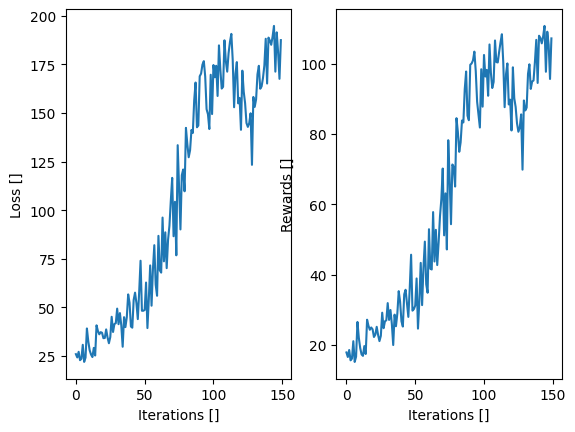

In [ ]:
# ----------- Your code here --------------------->

rewards_total = np.array([sum(map(sum, iteration_rewards)) for iteration_rewards in iterations_rewards])
losses_total = np.array([sum(map(sum, iteration_losses)) for iteration_losses in iterations_losses])

plt.figure()
plt.subplot(121)
plt.plot(np.arange(N_ITERATIONS), rewards_total/N_EPISODES_PER_ITERATION)
plt.xlabel('Iterations []')
plt.ylabel('Loss []')

plt.subplot(122)
plt.plot(np.arange(N_ITERATIONS), losses_total/N_EPISODES_PER_ITERATION)
plt.xlabel('Iterations []')
plt.ylabel('Rewards []')

# ------------------------------------------------>




## 6.5. Test de la policy apprise



**Question 6.5: complétez enfin ce code permettant de tester la policy apprise**


In [ ]:
# parametres
N_STEPS_MAX_PER_EPISODE = 300


In [ ]:
# ----------------------------------->
# test de la policy apprise
# ----------------------------------->

# initialisation de l'environnement
env = gym.make('CartPole-v1', render_mode="rgb_array")

# on fixe la graine aléatoire
# env.seed(SEED)


# recupération de la première obs/state
obs, info = env.reset(seed=SEED)


# boucle temporelle d'interactions
steps_rewards = []
frames = []
for step in range(N_STEPS_MAX_PER_EPISODE):

    # recuperation de l'environnement courant
    frames.append(env.render())

    # select action (ne pas utiliser la méthode .predict mais l'appel au model simple (model(obs[np.newaxis]) pour la mise en batch))

# ----------- Your code here --------------------->

    _, left_proba = select_action(obs, mode='training')

# ------------------------------------------------>

    # exploration or action strategy (no exploration in testing mode)

# ----------- Your code here --------------------->

    go_right, _ = select_action(obs, mode='training')

# ------------------------------------------------>

    # interaction: recupération de la récompense et de la nouvelle observation
    obs, reward, done, truncated, info = env.step(go_right)

    # mise à jour de la liste des rewards
    steps_rewards.append(reward)


    # continue or not
    if done or truncated:
        break

# output
env.close()


**Question: Evaluer cette policy**



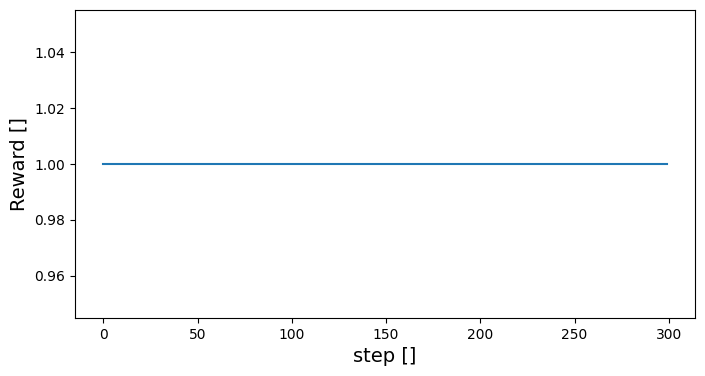

In [ ]:

# ----------- Your code here --------------------->

plt.figure(figsize=(8, 4))
plt.plot(np.arange(len(steps_rewards)), np.array(steps_rewards))
plt.xlabel("step []", fontsize=14)
plt.ylabel("Reward []", fontsize=14)
plt.show()

# ------------------------------------------------>



**Affichage**

In [ ]:
plot_animation(frames)